In [1]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model,feature_selection,preprocessing
from statsmodels.tools.eval_measures import mse
from statsmodels.tools.tools import add_constant
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.metrics import mean_absolute_percentage_error

import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib.ticker import StrMethodFormatter
import scipy as imposp
from scipy import stats
import plotly.offline as po
import plotly.graph_objs as go
from numpy import median
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FormatStrFormatter
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
df=pd.read_csv('test2.csv')

In [3]:
df.shape

(13886, 108)

In [4]:
pd.set_option('display.max_columns', None)

In [5]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13886 entries, 0 to 13885
Data columns (total 108 columns):
 #   Column                                 Dtype  
---  ------                                 -----  
 0   livingAreaValue                        float64
 1   zipcode                                int64  
 2   bathrooms                              int64  
 3   bedrooms                               int64  
 4   annualHomeownersInsurance              int64  
 5   yearBuilt                              float64
 6   resoFacts.yearBuiltEffective           float64
 7   price                                  int64  
 8   monthlyHoaFee                          int64  
 9   solarPotential.sunScore                float64
 10  resoFacts.hasGarage                    int64  
 11  resoFacts.waterViewYN                  int64  
 12  resoFacts.daysOnZillow                 int64  
 13  resoFacts.bathroomsHalf                float64
 14  resoFacts.bathroomsFull                int64  
 15  r

In [6]:
df['age_median_bin']=pd.cut(df.age_median,bins = [10,20,30,40,50,60,90],labels=['10-20','20-30','30-40','40-50',
                                                                               '50-60','60-90'])
df['yearBuilt_bin']=pd.cut(df.yearBuilt,bins = [0,1980,2023],labels=['Pre-1980s','1980s+'])

In [7]:
df['bathroom_bins']=pd.cut(df.bathrooms,bins = [0,1,2,3,4,5,6,12],labels=['1','2','3','4','5','6','6+'])
df['bedroom_bins']=pd.cut(df.bedrooms,bins = [0,1,2,3,4,5,6,8],labels=['1','2','3','4','5','6','6+'])

In [8]:
#One hot encoding
df=pd.get_dummies(df, columns=['age_median_bin','bathroom_bins','bedroom_bins','yearBuilt_bin'
                              ])#, drop_first=True)

In [9]:
#df.info(verbose=True)

In [10]:
x=df.drop(['resoFacts.architecturalStyle','resoFacts.subdivisionName','resoFacts.propertyCondition','State','price',
           'male','female',
           'race_white','race_black','race_asian','race_native','race_pacific','race_other','race_multiple','hispanic',
           'mortgage','annualHomeownersInsurance','resoFacts.pricePerSquareFoot',
           'zipcode','resoFacts.hasOpenParking','farmer','disabled','veteran',
            'resoFacts.bathroomsHalf','resoFacts.bathroomsFull',
           'family_size','family_dual_income','widowed','education_stem_degree',
           'income_household_under_5','income_household_5_to_10','income_household_10_to_15',
           'income_household_15_to_20','income_household_20_to_25','income_household_25_to_35',
           'income_household_35_to_50','income_household_50_to_75','income_household_75_to_100',
           'income_individual_median','limited_english','resoFacts.daysOnZillow',
           'resoFacts.yearBuiltEffective','resoFacts.taxAnnualAmount','yearBuilt',
           'education_less_highschool','education_highschool','education_some_college', 
              'poverty','health_uninsured','resoFacts.hasGarage','resoFacts.isNewConstruction',
           'resoFacts.hasView','population','solarPotential.sunScore',
           'age_under_10','age_10_to_19','age_20s','age_30s','age_40s','age_50s','age_60s','age_70s',
           'age_over_80','education_college_or_above','labor_force_participation',
           'unemployment_rate','education_bachelors','education_graduate',
           'density','elementary school score','listed_by.rating_average',
            'divorced','income_household_100_to_150',
           'citylabel_Columbus','income_household_six_figure','income_household_median_bin_0-100k',
           'age_median_bin_10-20','age_median_bin_50-60','age_median_bin_60-90',
           'age_median_bin_40-50','age_median_bin_20-30','bathroom_bins_6','bathroom_bins_6+',
           'bathroom_bins_1','bedroom_bins_6+','income_household_median','yearBuilt_bin_Pre-1980s'
          ], axis=1)
y=df[['price']]
y.head()

,price
0,275000
1,105000
2,275000
3,289000
4,260000


In [11]:
x.head()

,livingAreaValue,bathrooms,bedrooms,monthlyHoaFee,resoFacts.waterViewYN,resoFacts.hasAttachedGarage,walkScore.walkscore,transitScore.transit_score,age_median,married,never_married,income_household_150_over,home_ownership,commute_time,citylabel_Alexandria,citylabel_Arlington,citylabel_Baltimore,citylabel_Boston,citylabel_Brooklyn,citylabel_Charlotte,citylabel_Connecticut,citylabel_Jersey City,citylabel_Manhattan,citylabel_Philadelphia,citylabel_Pittsburgh,citylabel_Queens,citylabel_Staten Island,citylabel_Washington D.C.,citylabel_Yonkers,income_household_median_bin_100k-200k,income_household_median_bin_200k-250k,age_median_bin_30-40,bathroom_bins_2,bathroom_bins_3,bathroom_bins_4,bathroom_bins_5,bedroom_bins_1,bedroom_bins_2,bedroom_bins_3,bedroom_bins_4,bedroom_bins_5,bedroom_bins_6,yearBuilt_bin_1980s+
0,943.0,2,2,148,0,0,96,78.0,33.5,35.8,51.3,24.8,41.9,31.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0
1,1230.0,2,2,893,0,0,48,46.0,35.5,21.5,55.6,3.7,48.8,34.7,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0
2,746.0,1,1,253,0,0,99,100.0,36.2,33.9,51.2,26.5,33.1,25.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
3,799.0,1,1,465,0,0,98,94.0,38.6,38.0,46.1,34.1,49.1,29.2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0
4,660.0,1,1,213,0,0,99,100.0,38.6,38.0,46.1,34.1,49.1,29.2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0


In [12]:
#df3 dataframe created to examine multicollinearity
#Acceptable VIF is max of 10
#Source: https://towardsdatascience.com/everything-you-need-to-know-about-multicollinearity-2f21f082d6dc
df3=x
vif_data=pd.DataFrame()
vif_data["feature"]=df3.columns
vif_data["VIF"]=[variance_inflation_factor(df3.values,i) for i in range(len(df3.columns))]

In [13]:
vif_data

,feature,VIF
0,livingAreaValue,12.518975
1,bathrooms,56.566791
2,bedrooms,268.634184
3,monthlyHoaFee,1.829927
4,resoFacts.waterViewYN,33.411609
5,resoFacts.hasAttachedGarage,6.512841
6,walkScore.walkscore,105.632901
7,transitScore.transit_score,122.712315
8,age_median,106.479300
9,married,85.310624


In [14]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,random_state=42)
linearmodel1 = sm.OLS(y_train, add_constant(x_train)).fit()
print(linearmodel1.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.745
Model:                            OLS   Adj. R-squared:                  0.744
Method:                 Least Squares   F-statistic:                     752.3
Date:                Mon, 30 May 2022   Prob (F-statistic):               0.00
Time:                        15:02:38   Log-Likelihood:            -1.6255e+05
No. Observations:               11108   AIC:                         3.252e+05
Df Residuals:                   11064   BIC:                         3.255e+05
Df Model:                          43                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

In [15]:
y_pred = linearmodel1.predict(add_constant(x_test))

In [16]:
#MAE
mean_absolute_error(y_test, y_pred)

363486.98770717764

In [17]:
#MAPE
from sklearn.metrics import mean_absolute_percentage_error

mean_absolute_percentage_error(y_test, y_pred)

0.5881924225680872

In [18]:
#RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)
rmse

562707.1074956304

In [19]:
#Plot test errors by features

In [20]:
y_test=y_test.reset_index()

In [21]:
y_test

,index,price
0,6431,350000
1,3143,820000
2,3193,849000
3,9628,475000
4,4046,150000
...,...,...
2773,3997,1625000
2774,12137,1375000
2775,4035,290000
2776,12765,2850000


In [22]:
y_pred=y_pred.reset_index()

In [23]:
y_pred

,index,0
0,6431,7.682474e+05
1,3143,1.087628e+06
2,3193,1.018880e+06
3,9628,9.453700e+05
4,4046,-1.916987e+05
...,...,...
2773,3997,2.580059e+06
2774,12137,1.841057e+06
2775,4035,4.029365e+04
2776,12765,2.463135e+06


In [24]:
x_test=x_test.reset_index()

In [25]:
#df2 dataframe is to treat errors
df2 = pd.merge(pd.merge(x_test,y_test,on='index'),y_pred,on='index')

In [26]:
df2['error']=abs(df2['price']-df2[0]).round()

In [27]:
#df2.dtypes

In [28]:
#Examine errors
numerical=[
    'livingAreaValue','bathrooms','bedrooms','monthlyHoaFee','resoFacts.waterViewYN','resoFacts.hasAttachedGarage',
'walkScore.walkscore','age_median','married','never_married',
'income_household_150_over','home_ownership','commute_time','price'                             
]

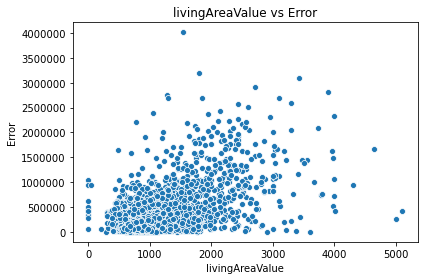

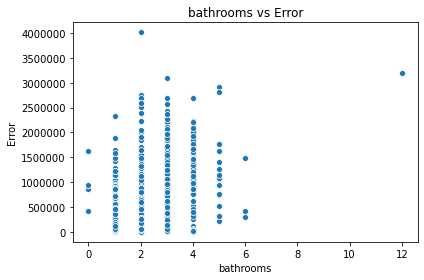

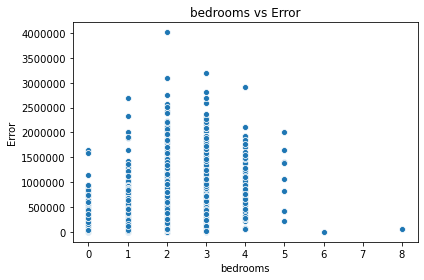

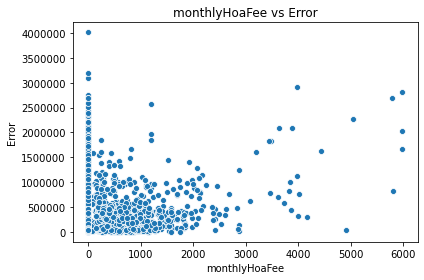

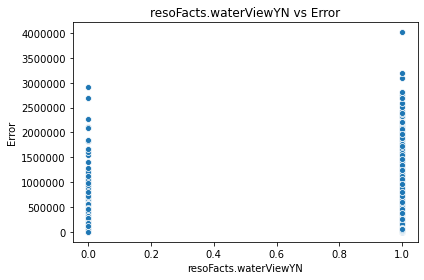

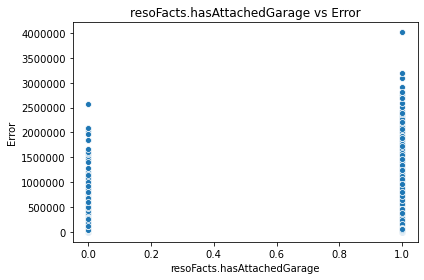

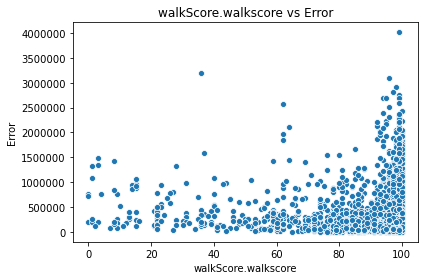

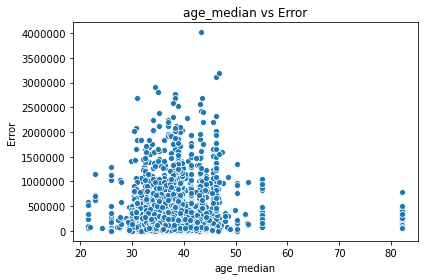

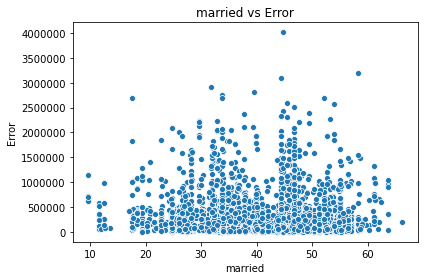

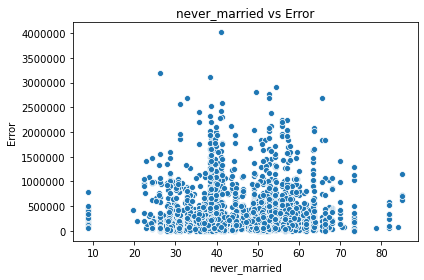

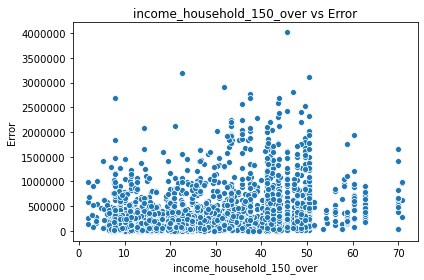

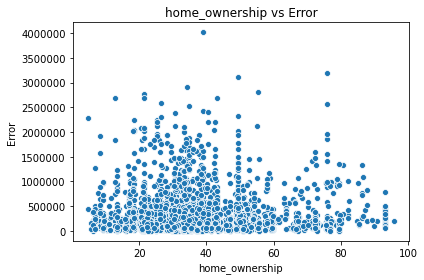

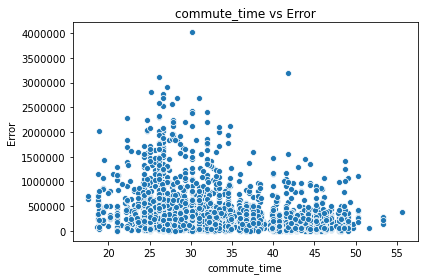

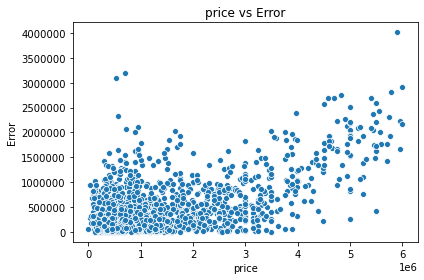

In [29]:
#Error v Relevant Features
for x in numerical:
    sns.scatterplot(data=df2, x=x, y='error')
    plt.ticklabel_format(style='plain', axis='y')
    plt.title(str(x)+' vs Error')
    plt.xlabel(x)
    plt.ylabel("Error")
    plt.tight_layout()
#So that axis show
    plt.show()

In [30]:
#sort absolute value of error descending
pd.set_option('display.max_columns', None)
df2=df2.sort_values(by=['error'],ascending=False)

In [31]:
#Using Multi-City model, print out undervalued condo errors less than or equal 325k in Philadelphia
df2[(df2.citylabel_Philadelphia==1) & (df2.price<=325000) & (df2.price<df2[0])].sort_values(by=['error'],ascending=False)

,index,livingAreaValue,bathrooms,bedrooms,monthlyHoaFee,resoFacts.waterViewYN,resoFacts.hasAttachedGarage,walkScore.walkscore,transitScore.transit_score,age_median,married,never_married,income_household_150_over,home_ownership,commute_time,citylabel_Alexandria,citylabel_Arlington,citylabel_Baltimore,citylabel_Boston,citylabel_Brooklyn,citylabel_Charlotte,citylabel_Connecticut,citylabel_Jersey City,citylabel_Manhattan,citylabel_Philadelphia,citylabel_Pittsburgh,citylabel_Queens,citylabel_Staten Island,citylabel_Washington D.C.,citylabel_Yonkers,income_household_median_bin_100k-200k,income_household_median_bin_200k-250k,age_median_bin_30-40,bathroom_bins_2,bathroom_bins_3,bathroom_bins_4,bathroom_bins_5,bedroom_bins_1,bedroom_bins_2,bedroom_bins_3,bedroom_bins_4,bedroom_bins_5,bedroom_bins_6,yearBuilt_bin_1980s+,price,0,error
1741,101,1001.0,2,1,923,0,0,99,100.0,31.6,31.4,59.2,34.9,27.7,24.8,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,319900,672701.865432,352802.0
1409,103,1200.0,1,1,0,0,0,94,100.0,32.5,26.8,59.9,25.8,33.1,31.5,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,229900,561476.309861,331576.0
270,181,951.0,1,1,660,0,0,100,100.0,31.6,31.4,59.2,34.9,27.7,24.8,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,304900,444776.442061,139876.0
1273,50,883.0,1,1,956,0,0,99,100.0,31.6,31.4,59.2,34.9,27.7,24.8,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,249900,365730.147891,115830.0
219,99,665.0,1,1,727,0,0,100,100.0,36.2,33.9,51.2,26.5,33.1,25.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,98115,170354.293349,72239.0
779,41,1000.0,1,1,224,0,0,94,72.0,32.5,26.8,59.9,25.8,33.1,31.5,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,314999,338152.389059,23153.0
709,304,717.0,1,1,614,0,0,99,100.0,31.6,31.4,59.2,34.9,27.7,24.8,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,309900,330989.456795,21089.0
1312,434,979.0,1,1,200,0,0,98,70.0,32.5,26.8,59.9,25.8,33.1,31.5,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,320000,331374.211486,11374.0
100,168,618.0,1,1,483,0,0,99,100.0,36.2,33.9,51.2,26.5,33.1,25.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,174500,180120.280096,5620.0
